In [ ]:
# ==========================================================
# ① best.pt 모델로 test셋 평가
# ==========================================================
from ultralytics import YOLO
from pathlib import Path

ROOT      = Path(r"E:\pytorch_env\ai05-level1-project")
PROJECT   = ROOT / "Exp"

RUN_NAME  = "aug_s0.20_h0.00_v0.40_v8n_640_AdamW_lr0.003_ep70_p10_mosaic0.0"
MODEL_PT  = PROJECT / RUN_NAME / "weights" / "best.pt"

DATA_YAML = r"E:\pytorch_env\CombinedDataset3\data_70_15_15_split.yaml"

assert MODEL_PT.exists(), f"best.pt 없음: {MODEL_PT}"
model = YOLO(str(MODEL_PT))

test_run_name = f"{RUN_NAME}_test"

metrics = model.val(
    data=DATA_YAML,
    split="test",
    imgsz=640,
    batch=16,
    save=True,
    save_hybrid=True,
    project=str(PROJECT),
    name=test_run_name
)

print(metrics)


WARNING 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.3.221  Python-3.11.14 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
Model summary (fused): 72 layers, 3,091,487 parameters, 0 gradients, 8.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1491.61155.9 MB/s, size: 724.5 KB)
val: Scanning E:\pytorch_env\CombinedDataset3\test\labels.cache... 221 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 221/221  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 14/14 8.8it/s 1.6s<0.2s
                   all        221        842      0.951      0.954       0.99      0.981
             5mg         18         18      0.989          1      0.995      0.995
          800mg         25         25       0.94          1      0.995      0.995
          500/20mg         23         26      0.995          1      0.995      0.975
                            7          7      0.958          

[INFO] leader_test_map head:


,precision,recall,mAP50,mAP50-95,fitness
0,0.951161,0.953517,0.989972,0.980809,0.980809


[INFO] test_per_class_map head:


,class_id,class_name,num_objects,mAP50-95
0,0,보령부스파정 5mg,18,0.995000
1,1,동아가바펜틴정 800mg,25,0.995000
2,2,낙소졸정 500/20mg,26,0.974591
3,3,신바로정,7,0.995000
4,4,가바토파정 100mg,13,0.995000



[SUMMARY] Test mAP50-95 = 0.9808 (mAP50 = 0.9900)
[SUMMARY] Precision = 0.9512, Recall = 0.9535


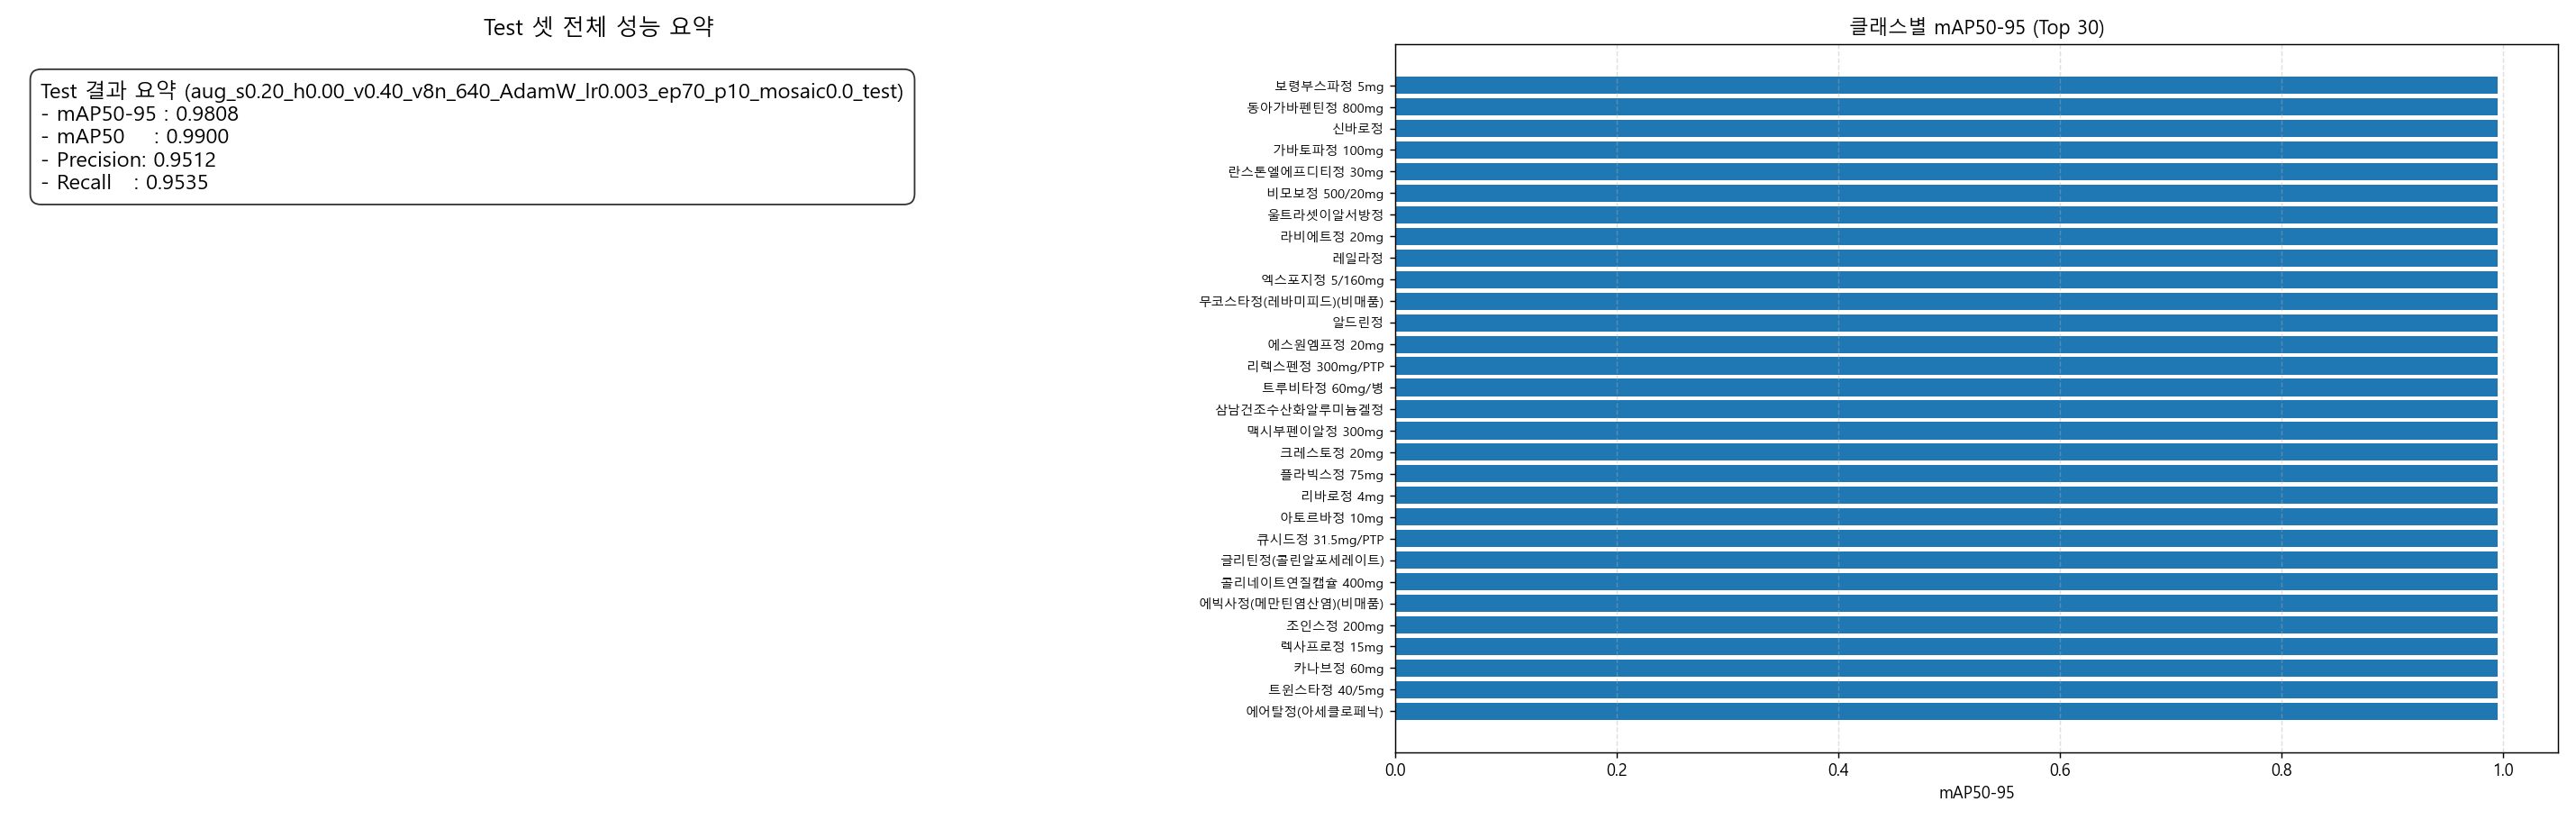

[OK] Plot saved: E:\pytorch_env\ai05-level1-project\Exp\aug_s0.20_h0.00_v0.40_v8n_640_AdamW_lr0.003_ep70_p10_mosaic0.0_test\test_results_overview_aug_s0.20_h0.00_v0.40_v8n_640_AdamW_lr0.003_ep70_p10_mosaic0.0_test.png
[OK] Copied to report: E:\pytorch_env\codeitteam7\img\test_results_overview_aug_s0.20_h0.00_v0.40_v8n_640_AdamW_lr0.003_ep70_p10_mosaic0.0_test.png


In [9]:
# ==========================================================
# test셋 mAP 결과 시각화 (leader_test_map + test_per_class_map)
# ==========================================================
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import matplotlib

# 한글 폰트 & 마이너스 설정
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# ----------------------------------------------------------
# 1) 경로 설정
# ----------------------------------------------------------
ROOT        = Path(r"E:\pytorch_env\ai05-level1-project")
PROJECT     = ROOT / "Exp"

# 🔹 test 결과가 저장된 폴더명 (이미 존재하는 폴더)
RUN_NAME_TEST = "aug_s0.20_h0.00_v0.40_v8n_640_AdamW_lr0.003_ep70_p10_mosaic0.0_test"

exp_dir     = PROJECT / RUN_NAME_TEST
REPORT_DIR  = Path(r"E:\pytorch_env\codeitteam7\img")

leader_csv  = exp_dir / "leader_test_map.csv"
per_csv     = exp_dir / "test_per_class_map.csv"

assert leader_csv.exists(), f"leader_test_map.csv 없음: {leader_csv}"
assert per_csv.exists(),    f"test_per_class_map.csv 없음: {per_csv}"

# ----------------------------------------------------------
# 2) CSV 로드
# ----------------------------------------------------------
leader_df = pd.read_csv(leader_csv)
per_df    = pd.read_csv(per_csv)

print("[INFO] leader_test_map head:")
display(leader_df.head())
print("[INFO] test_per_class_map head:")
display(per_df.head())

# ----------------------------------------------------------
# 3) 전체 mAP50-95, mAP50, Precision, Recall 등 (있으면) 뽑기
#    - leader_test_map.csv 구조에 맞게 컬럼 자동 탐색
# ----------------------------------------------------------
def pick(cols, df):
    for c in cols:
        if c in df.columns:
            return c
    return None

m9595_col = pick(["mAP50-95", "metrics/mAP50-95(B)", "mAP50_95", "mAP"], leader_df)
m50_col   = pick(["mAP50", "metrics/mAP50(B)", "mAP_0.5"], leader_df)
p_col     = pick(["precision", "metrics/precision(B)"], leader_df)
r_col     = pick(["recall", "metrics/recall(B)"], leader_df)

overall = leader_df.iloc[0]  # 보통 1줄짜리

m9595 = float(overall[m9595_col]) if m9595_col else None
m50   = float(overall[m50_col])   if m50_col   else None
prec  = float(overall[p_col])     if p_col     else None
rec   = float(overall[r_col])     if r_col     else None

print(f"\n[SUMMARY] Test mAP50-95 = {m9595:.4f} (mAP50 = {m50:.4f})")
if prec is not None and rec is not None:
    print(f"[SUMMARY] Precision = {prec:.4f}, Recall = {rec:.4f}")

# ----------------------------------------------------------
# 4) 클래스별 mAP50-95 막대 그래프
#    - 여기서 문제가 되었던 부분: 컬럼명을 명시적으로 지정!
# ----------------------------------------------------------
cls_col = "class_name"   # ✅ CSV에 실제로 있는 컬럼명
map_col = "mAP50-95"     # ✅ CSV에 실제로 있는 컬럼명

# 숫자형 변환(혹시 모를 문자열/NaN 대비)
per_df[map_col] = pd.to_numeric(per_df[map_col], errors="coerce")

# mAP 기준 내림차순 정렬 (위에서 잘 보이게)
per_sorted = per_df.sort_values(map_col, ascending=False).reset_index(drop=True)

# 너무 많으면 상위 N개만 보기 (원하면 숫자 바꿔도 됨)
TOP_K = 30
per_top = per_sorted.head(TOP_K)

# ----------------------------------------------------------
# 5) 시각화 (1) 전체 요약 + (2) 클래스별 막대그래프
# ----------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(22, 7), dpi=130)

# (1) 왼쪽: overall 텍스트 요약 박스 + 간단한 게이지 느낌
ax0 = axes[0]
ax0.axis("off")

text_lines = [f"Test 결과 요약 ({RUN_NAME_TEST})"]
if m9595_col:
    text_lines.append(f"- mAP50-95 : {m9595:.4f}")
if m50_col:
    text_lines.append(f"- mAP50    : {m50:.4f}")
if p_col:
    text_lines.append(f"- Precision: {prec:.4f}")
if r_col:
    text_lines.append(f"- Recall   : {rec:.4f}")

ax0.text(
    0.02, 0.95, "\n".join(text_lines),
    va="top", ha="left", fontsize=13,
    bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", alpha=0.8)
)

ax0.set_title("Test 셋 전체 성능 요약", fontsize=14)

# (2) 오른쪽: 클래스별 mAP50-95 막대그래프
ax1 = axes[1]

y_pos = np.arange(len(per_top))
ax1.barh(y_pos, per_top[map_col])
ax1.set_yticks(y_pos)
ax1.set_yticklabels(per_top[cls_col], fontsize=8)
ax1.invert_yaxis()  # 높은 mAP이 위로 오게
ax1.set_xlabel("mAP50-95")
ax1.set_title(f"클래스별 mAP50-95 (Top {TOP_K})")
ax1.grid(axis="x", ls="--", alpha=0.4)

# x축을 [0, 1.05] 정도로 고정
ax1.set_xlim(0, 1.05)

plt.tight_layout()

# ----------------------------------------------------------
# 6) 저장 & 복사
# ----------------------------------------------------------
plot_name = f"test_results_overview_{RUN_NAME_TEST}.png"
out_png   = exp_dir / plot_name
plt.savefig(out_png)

from IPython.display import Image, display
display(Image(filename=out_png))

print(f"[OK] Plot saved: {out_png}")

REPORT_DIR.mkdir(parents=True, exist_ok=True)
dst = REPORT_DIR / plot_name
shutil.copyfile(out_png, dst)
print(f"[OK] Copied to report: {dst}")
